In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
env_path = project_root / 'config' / '.env'
load_dotenv(env_path)

from src.database import DatabaseConnection

# Load predictions from database
db = DatabaseConnection()
predictions_df = pd.read_sql("SELECT * FROM model_predictions", db.engine)

print("="*80)
print("PREDICTIONS ANALYSIS & VISUALIZATION")
print("="*80)

PREDICTIONS ANALYSIS & VISUALIZATION


In [2]:
# 1. Overall Performance
print("\n1. OVERALL PREDICTION PERFORMANCE")
print(f"   Total predictions: {len(predictions_df)}")
print(f"   Correct: {predictions_df['correct_prediction'].sum()} ({predictions_df['correct_prediction'].mean()*100:.2f}%)")
print(f"   Incorrect: {(1-predictions_df['correct_prediction']).sum()} ({(1-predictions_df['correct_prediction']).mean()*100:.2f}%)")



1. OVERALL PREDICTION PERFORMANCE
   Total predictions: 7500
   Correct: 4581 (61.08%)
   Incorrect: 2919 (38.92%)


In [4]:
# 2. Prediction Distribution
print("\n2. PREDICTION DISTRIBUTION")
print(f"   Predicted Readmitted: {predictions_df['predicted_readmitted'].sum()}")
print(f"   Predicted Not Readmitted: {(1-predictions_df['predicted_readmitted']).sum()}")



2. PREDICTION DISTRIBUTION
   Predicted Readmitted: 3391
   Predicted Not Readmitted: 4109


In [5]:
# 3. Probability Statistics
print("\n3. PREDICTION PROBABILITY STATISTICS")
print(f"   Mean: {predictions_df['prediction_probability'].mean():.4f}")
print(f"   Median: {predictions_df['prediction_probability'].median():.4f}")
print(f"   Std Dev: {predictions_df['prediction_probability'].std():.4f}")
print(f"   Min: {predictions_df['prediction_probability'].min():.4f}")
print(f"   Max: {predictions_df['prediction_probability'].max():.4f}")


3. PREDICTION PROBABILITY STATISTICS
   Mean: 0.4964
   Median: 0.4818
   Std Dev: 0.1298
   Min: 0.1864
   Max: 0.9065


In [6]:
# 4. Risk Category Distribution
print("\n4. RISK CATEGORY DISTRIBUTION")
risk_dist = predictions_df['risk_category'].value_counts().sort_index()
for risk, count in risk_dist.items():
    pct = count / len(predictions_df) * 100
    print(f"   {risk}: {count} ({pct:.2f}%)")



4. RISK CATEGORY DISTRIBUTION
   High: 2845 (37.93%)
   Low: 302 (4.03%)
   Medium: 3807 (50.76%)
   Very High: 546 (7.28%)


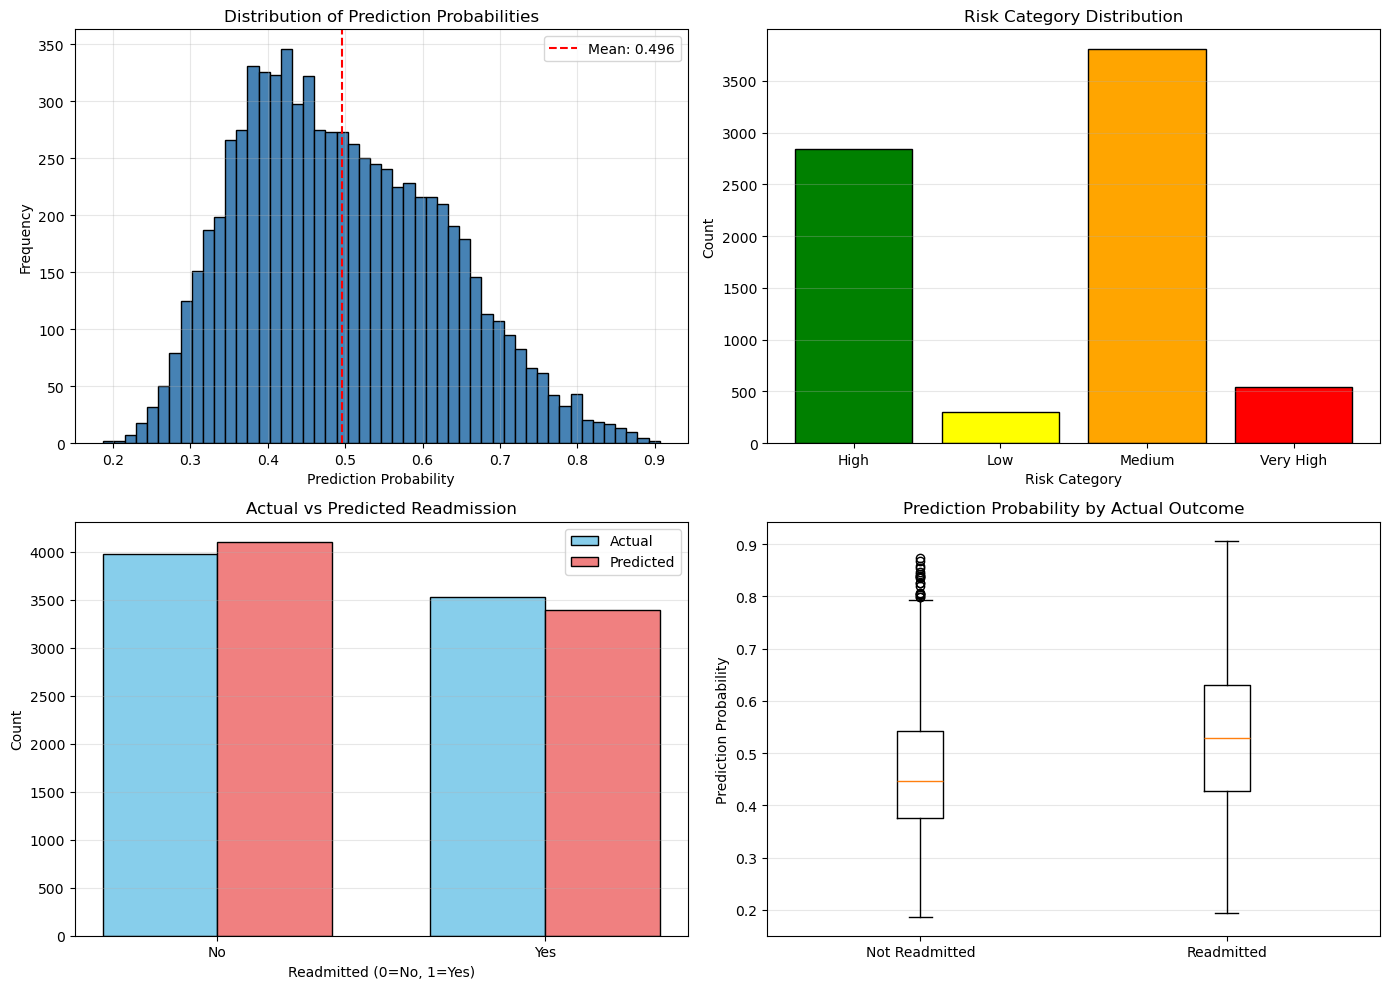

In [8]:
# 5. Visualization: Prediction Probability Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Plot 1: Histogram of prediction probabilities
ax = axes[0, 0]
ax.hist(predictions_df['prediction_probability'], bins=50, color='steelblue', edgecolor='black')
ax.axvline(predictions_df['prediction_probability'].mean(), color='red', linestyle='--', label=f'Mean: {predictions_df["prediction_probability"].mean():.3f}')
ax.set_xlabel('Prediction Probability')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Prediction Probabilities')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Risk Category Distribution
ax = axes[0, 1]
risk_counts = predictions_df['risk_category'].value_counts().sort_index()
colors = ['green', 'yellow', 'orange', 'red']
ax.bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='black')
ax.set_xlabel('Risk Category')
ax.set_ylabel('Count')
ax.set_title('Risk Category Distribution')
ax.grid(alpha=0.3, axis='y')

# Plot 3: Actual vs Predicted
ax = axes[1, 0]
comparison = pd.crosstab(
    predictions_df['actual_readmitted'],
    predictions_df['predicted_readmitted'],
    margins=True
)
comparison_pct = pd.crosstab(
    predictions_df['actual_readmitted'],
    predictions_df['predicted_readmitted'],
    normalize='index'
) * 100

x = np.arange(2)
width = 0.35
actual_counts = predictions_df['actual_readmitted'].value_counts().sort_index()
predicted_counts = predictions_df['predicted_readmitted'].value_counts().sort_index()

ax.bar(x - width/2, actual_counts, width, label='Actual', color='skyblue', edgecolor='black')
ax.bar(x + width/2, predicted_counts, width, label='Predicted', color='lightcoral', edgecolor='black')
ax.set_xlabel('Readmitted (0=No, 1=Yes)')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Readmission')
ax.set_xticks(x)
ax.set_xticklabels(['No', 'Yes'])
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Plot 4: Probability by Actual Outcome
ax = axes[1, 1]
readmitted = predictions_df[predictions_df['actual_readmitted'] == 1]['prediction_probability']
not_readmitted = predictions_df[predictions_df['actual_readmitted'] == 0]['prediction_probability']

ax.boxplot([not_readmitted, readmitted], labels=['Not Readmitted', 'Readmitted'])
ax.set_ylabel('Prediction Probability')
ax.set_title('Prediction Probability by Actual Outcome')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [9]:
# 6. Confusion Matrix Analysis
print("\n5. CONFUSION MATRIX ANALYSIS")
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(predictions_df['actual_readmitted'], predictions_df['predicted_readmitted'])
print(f"\nConfusion Matrix:")
print(f"   True Negative:  {cm[0][0]}")
print(f"   False Positive: {cm[0][1]}")
print(f"   False Negative: {cm[1][0]}")
print(f"   True Positive:  {cm[1][1]}")

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"\nDetailed Metrics:")
print(f"   Sensitivity (Recall): {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")
print(f"   Positive Predictive Value (PPV): {ppv:.4f}")
print(f"   Negative Predictive Value (NPV): {npv:.4f}")


5. CONFUSION MATRIX ANALYSIS

Confusion Matrix:
   True Negative:  2582
   False Positive: 1392
   False Negative: 1527
   True Positive:  1999

Detailed Metrics:
   Sensitivity (Recall): 0.5669
   Specificity: 0.6497
   Positive Predictive Value (PPV): 0.5895
   Negative Predictive Value (NPV): 0.6284


In [10]:
# 7. High-Risk Patients
print("\n6. HIGH-RISK PATIENTS (Probability > 0.7)")
high_risk = predictions_df[predictions_df['prediction_probability'] > 0.7]
print(f"   Total high-risk patients: {len(high_risk)}")
print(f"   Actually readmitted: {high_risk['actual_readmitted'].sum()}")
print(f"   Readmission rate in high-risk group: {high_risk['actual_readmitted'].mean()*100:.2f}%")



6. HIGH-RISK PATIENTS (Probability > 0.7)
   Total high-risk patients: 546
   Actually readmitted: 418
   Readmission rate in high-risk group: 76.56%


In [11]:
# 8. Model Performance by Risk Category
print("\n7. MODEL PERFORMANCE BY RISK CATEGORY")
for risk in ['Low', 'Medium', 'High', 'Very High']:
    subset = predictions_df[predictions_df['risk_category'] == risk]
    accuracy = subset['correct_prediction'].mean()
    readmit_rate = subset['actual_readmitted'].mean()
    print(f"   {risk}: Accuracy={accuracy:.4f}, Actual Readmit Rate={readmit_rate*100:.2f}%")

print("\n✓ Analysis complete!")


7. MODEL PERFORMANCE BY RISK CATEGORY
   Low: Accuracy=0.7384, Actual Readmit Rate=26.16%
   Medium: Accuracy=0.6196, Actual Readmit Rate=38.04%
   High: Accuracy=0.5557, Actual Readmit Rate=55.57%
   Very High: Accuracy=0.7656, Actual Readmit Rate=76.56%

✓ Analysis complete!
